# Notebook to test functions and behaviors of the matrix exponentiation

In [18]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax.scipy.optimize as jaxopt
import get_initialization_cond as init
import optimization_SPDC_gaussain_pump as gauss_opt
import scipy.linalg as lin

In [64]:
vp = 0.1
l = 1
wi = -8
wf = 8
Np = 0.02
N = 11
x = np.linspace(wi, wf, N)
w = np.linspace(2*wi, 2*wf, 2*N)
gauss_params = [0.1, 0.2, np.pi/7]
alpha, G, H, = init.get_constants(vp, l, wi, wf, Np, N = N)
U = np.array(gauss_opt.get_U_matrix(gauss_params, w, alpha, G, H, l))
right_fft = scipy.fft.fft(np.eye(len(w)))

In [77]:
fft = right_fft@U@np.conj(right_fft.T)/(2*N)
np.allclose(np.trace(fft), np.trace(U))

True

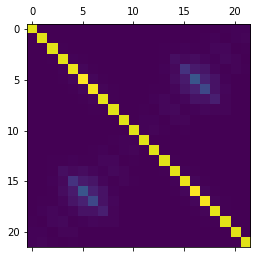

In [74]:
plt.matshow(np.abs(U))

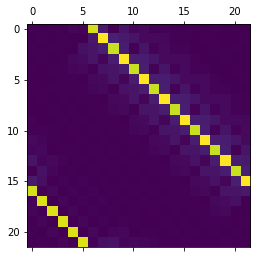

In [72]:
plt.matshow(np.abs(fft))
pump = gauss_opt.get_gaussian_pump(gauss_params, w)

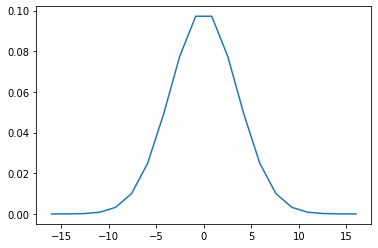

In [52]:
plt.plot(w, np.abs(pump))

In [2]:
def lin_reg(theta,x):
    w, b = theta
    return w*x+b
def least_square(theta, x, y):
    pred = lin_reg(theta, x)
    return jnp.mean((pred - y)**2)
def update(theta, x, y, lr = 0.2):
    return theta - lr*jax.grad(least_square, argnums=(0))(theta, x, y)

In [36]:
x = jnp.linspace(0,1,101)
theta = jnp.array([1.,1.])
y = 3*jnp.linspace(0,1,101)+0.5
for i in range(200):
      9     Returns a complex array with real part the first half of the input vector
     10     and the imaginary part the second half of the input vector.
   (...)
     21         array([complex]): vector initializing the optimization
     22     """
---> 23     if pump_shape == 0:
     24         real = theta[:len(theta)//2]
     25         imag = theta[len(theta)//2:]

    [... skipping hidden 1 frame]

File ~/.local/share/virtualenvs/optimal_pumps-vxukOnVz/lib/python3.9/site-packages/jax/core.py:1177, in concretization_function_error.<locals>.error(self, arg)
   1176 def error(self, arg):
-> 1177   raise ConcretizationTypeError(arg, fname_context)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function moving_window at /home/jiaqi/Downloads/masters/optimal_pumps/optimization_SPDC.py:31 for jit. This concrete value was not available in Python because it depends on the value of the argument 'size'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError
    theta = update(theta, x, y)

In [2]:
N = 401
wi = -10
wf = 10
l = 1
Np = 0.001
change = np.linspace(0.5,5,101)
x = np.linspace(wi,wf,N)
objective_f = []
N_pairs = []
alpha, G, H  = init.get_constants(l, wi, wf, Np, N = N)
for i in range(len(change)):
    x[N//2] = change[i]
    F = alpha*np.exp(-(x+x[:,np.newaxis])**2/2)
    #F = alpha*(x + x[:, np.newaxis])
    #F = np.array([[1,2,3],[2, 3, 1], [3,1,change[i]]])
    a = np.block([[G, F],[-np.conj(F).T, -H]])
    U = (scipy.linalg.expm(1j*a))[:N,N:]
    objective_f.append(((np.trace(np.conj(U)@U.T))**2/(np.trace((np.conj(U)@U.T)@(np.conj(U)@U.T))) - 1)**2 + (np.trace(np.conj(U)@U.T) - 1)**2)
    N_pairs.append(np.trace(np.conj(U)@U.T))

C:\Users\super\.virtualenvs\pump_optimization-rAbjnRJu\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


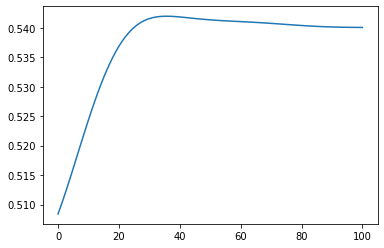

In [66]:
plt.plot(objective_f)

In [75]:
x = jnp.linspace(wi,wf,N)

C:\Users\super\AppData\Local\Temp\ipykernel_12124\2592801646.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, -np.log(x-x[-1])-np.log(x+x[-1]))
C:\Users\super\AppData\Local\Temp\ipykernel_12124\2592801646.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(x, -np.log(x-x[-1])-np.log(x+x[-1]))


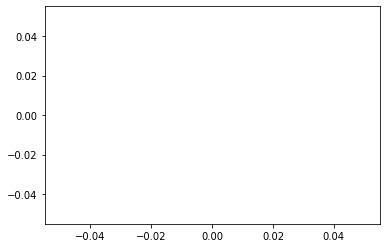

In [66]:
plt.plot(x, -np.log(x-x[-1])-np.log(x+x[-1]))

In [79]:
def loss(a, x, objective_value):
    return jnp.sum((a*(x-objective_value))**2)
a = jnp.exp(-x**2)

In [80]:
optim = jaxopt.minimize(loss, a, args=(x, 0), method = "BFGS")